# **Fish Analysis** 🐟🐠
`context`: Dataset recording various measurements of 7 different species of fish at a fish market. Predictive models can be used to predict weight, species, etc.

| **Attribute** | **Description** |  
|-------------|----------------|  
| **Species** | Species name of the fish |  
| **Weight**   | Weight of the fish in grams |  
| **Length1** (Standard Length) | Vertical length in cm |  
| **Length2** (Forked Length) | Diagonal length in cm |  
| **Length3** (Total Length) | Cross length in cm |  
| **Height**   | Height in cm from dorsal to the bottom thin |  
| **Width**    | Width in cm, thickness of the body |  

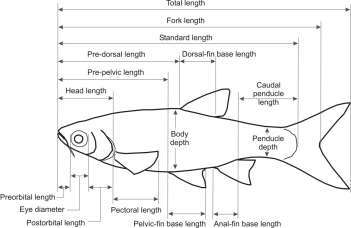

In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
from collections import Counter  

In [2]:
df = pd.read_csv('dataset/Fish.csv')

<div style="background-color:red; padding:30px; text-align:center; font-family:'Poppins'; font-size:30px; border-radius:10px ">1 | Exploratory Data Analysis </div>

In [3]:
df.head()

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340


In [4]:
df.shape 

(159, 7)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Species  159 non-null    object 
 1   Weight   159 non-null    float64
 2   Length1  159 non-null    float64
 3   Length2  159 non-null    float64
 4   Length3  159 non-null    float64
 5   Height   159 non-null    float64
 6   Width    159 non-null    float64
dtypes: float64(6), object(1)
memory usage: 8.8+ KB


In [6]:
df.describe().T 

,count,mean,std,min,25%,50%,75%,max
Weight,159.0,398.326415,357.978317,0.0000,120.00000,273.0000,650.0000,1650.000
Length1,159.0,26.247170,9.996441,7.5000,19.05000,25.2000,32.7000,59.000
Length2,159.0,28.415723,10.716328,8.4000,21.00000,27.3000,35.5000,63.400
Length3,159.0,31.227044,11.610246,8.8000,23.15000,29.4000,39.6500,68.000
Height,159.0,8.970994,4.286208,1.7284,5.94480,7.7860,12.3659,18.957
Width,159.0,4.417486,1.685804,1.0476,3.38565,4.2485,5.5845,8.142


In [7]:
df.describe(include='object').T 

,count,unique,top,freq
Species,159,7,Perch,56


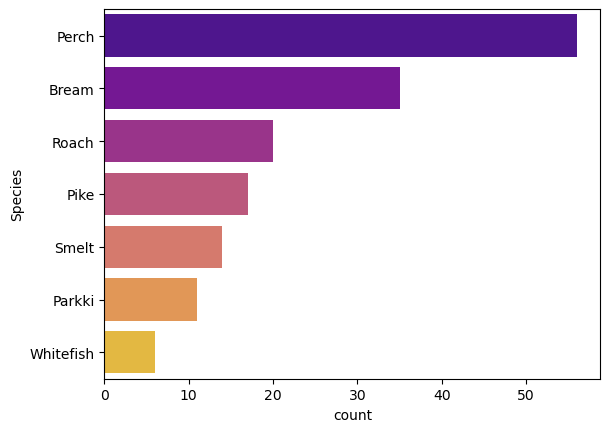

,Species,count
0,Perch,56
1,Bream,35
2,Roach,20
3,Pike,17
4,Smelt,14
5,Parkki,11
6,Whitefish,6


In [8]:
species = df['Species'].value_counts().reset_index()
sns.barplot(x=species['count'], y=species['Species'], hue=species['Species'], palette='plasma')
plt.show()
display(species)

In [23]:
plt.rcParams['figure.figsize'] = (15, 8)

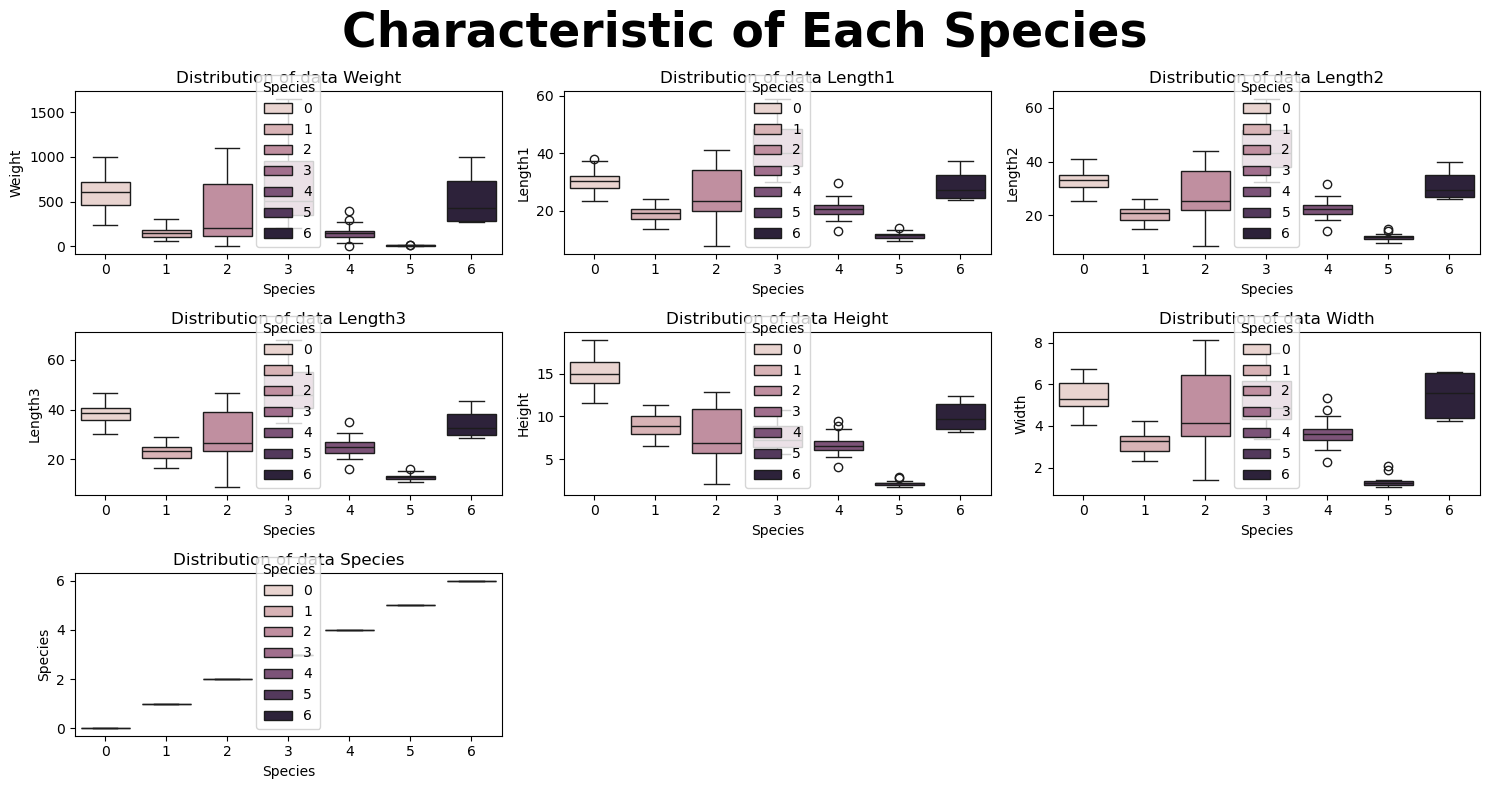

: 

In [ ]:
for i, col in enumerate(df.select_dtypes(include='number')):
    plt.subplot(3, 3, i+1)
    plt.title(f'Distribution of data {col}')
    sns.boxplot(data=df, x='Species', y=col, hue='Species')
    
plt.suptitle(f'Characteristic of Each Species', size=34, weight='bold')
plt.tight_layout()
plt.show()

In [10]:
bins = int(np.log(len(df) + 1))
bins 

5

In [11]:
def encoding(df, cols):
    for col in cols:
        df[col] = df[col].astype('category').cat.codes 
    return df

obj_cols = df.select_dtypes(include='object').columns 
df = encoding(df, obj_cols)

In [12]:
def mutual_information(crosstab):
    observed = np.array(crosstab.iloc[:-1, :-1])
    ratios = observed / np.sum(observed)
    Px = np.sum(ratios, axis=1, keepdims=True)
    Py = np.sum(ratios, axis=0, keepdims=True)
    nonzero = ratios > 0
    MI = np.sum(ratios[nonzero] * np.log(ratios[nonzero] / (Px @ Py)[nonzero]))
    return MI 

for col in df.select_dtypes(include='number').columns:
    X = np.array(df[col])
    X = np.digitize(X, bins=np.linspace(X.min(), X.max(), bins))
    X_df = pd.DataFrame(X.T)
    crosstab = pd.crosstab(X_df[0], df['Species'], margins=True)
    MI = mutual_information(crosstab)
    print(f'{col}: {MI}')

Species: 1.4032531260096341
Weight: 0.31847264820683024
Length1: 0.4145867164383449
Length2: 0.4078909484603002
Length3: 0.408731807240749
Height: 0.5654795543891399
Width: 0.4740951216468999


height and width has the highest mutual information

In [13]:
class Node:
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, info_gain=None, value=None, sample=None):
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right 
        self.info_gain = info_gain 
        self.value = value 
        self.sample = sample 

In [ ]:
class DecisionTreeClassifier:
    def __init__(self, max_depth=3, min_samples_split=10, min_samples_leaf=3, features=None, mode='entropy'):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.features = features
        self.mode = mode 
        self.feature_importance = None 
        
        
    def build_tree(self, dataset, curr_depth=0):
        X, Y = dataset[:, :-1], dataset[:, -1]
        n_samples, n_features = X.shape 
        
        if self.features is not None:
            features = self.features
        else:
            features = np.arange(n_features)
            
        if n_samples>=self.min_samples_split and curr_depth<=self.max_depth:
            best_split = self.get_best_split(dataset, n_samples, features)
            
            if best_split['info_gain']>0 and len(best_split['dataset_left'])>=self.min_samples_leaf and len(best_split['dataset_right'])>=self.min_samples_leaf:
                feature_index = best_split['feature_index']
                
                self.feature_importance[0][feature_index] += best_split['info_gain']
                self.feature_importance[1][feature_index] += 1
                
                left_subtree = self.build_tree(best_split['dataset_left'], curr_depth+1)
                right_subtree = self.build_tree(best_split['dataset_right'], curr_depth+1)
                return Node(
                    feature_index = feature_index,
                    threshold = best_split['threshold'],
                    left = left_subtree,
                    right = right_subtree,
                    info_gain = best_split['info_gain'],
                    sample = Y,
                )
                
        leaf_value = self.calc_leaf_value(Y)
        return Node(value=leaf_value, sample=Y)
    
    
    def get_best_split(self, dataset, n_samples, features):
        best_split = {}
        max_info_gain = -float('inf')
        
        for feature_index in features:
            possible_thresholds = np.unique(dataset[:, feature_index])
            
            for threshold in possible_thresholds:
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
                
                if len(dataset_left)>0 and len(dataset_right)>0:
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                    
                    curr_info_gain = self.information_gain(y, left_y, right_y, self.mode)
                    
                    if curr_info_gain > max_info_gain:
                        best_split = {
                            'feature_index': feature_index,
                            'threshold': threshold,
                            'dataset_left': dataset_left,
                            'dataset_right': dataset_right,
                            'info_gain': curr_info_gain,
                        }
                        max_info_gain = curr_info_gain
        return best_split
    
    
    def split(self, dataset, feature_index, threshold):
        dataset_left = np.array([row for row in dataset if row[feature_index] <= threshold])
        dataset_right = np.array([row for row in dataset if row[feature_index] > threshold])
        return dataset_left, dataset_right
    
    def calc_leaf_value(self, Y):
        Y = list(Y)
        return max(Y, key=Y.count)
    
    def information_gain(self, parent, l_child, r_child, mode):
        weigth_l = len(l_child) / len(parent)
        weigth_r = len(r_child) / len(parent)
        if mode == 'gini':
            gain = self.gini(parent) - (weigth_l*self.gini(l_child) + weigth_r*self.gini(r_child))
        else:
            gain = self.entropy(parent) - (weigth_l*self.entropy(l_child) + weigth_r*self.entropy(r_child))
        return gain
        
    def entropy(self, y):
        class_labels = np.unique(y)
        entropy = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            entropy += -p_cls * np.log(p_cls)
        return entropy
    
    def gini(self, y):
        class_labels = np.unique(y)
        gini = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            gini += p_cls ** 2
        return 1 - gini
    
    
    """POST PRUNING"""
    def cost_complexity_pruning(self, alpha=0.01, tree=None):
        if tree is None:
            tree = self.root
            
        if tree.left and tree.right:
            self.cost_complexity_pruning(alpha, tree.left)
            self.cost_complexity_pruning(alpha, tree.right)
            
            left_cost = self._calc_subtree_cost(tree.left)
            right_cost = self._calc_subtree_cost(tree.right)
            
            if (left_cost + right_cost - 1) * alpha >= tree.info_gain:
                tree.value = self.calc_leaf_value([leaf.value for leaf in self._get_leaves(tree)]) 
                tree.left = None
                tree.right = None 
        return tree
    
    def _get_leaves(self, tree):
        if tree is not None:
            return [tree]
        return self._get_leaves(tree.left) + self._get_leaves(tree.right)
    
    def _calc_subtree_cost(self, tree):
        if tree is not None:
            return 0
        
        if tree.value is not None:
            y = np.array(tree.sample)
            if self.mode == 'gini':
                self.gini(y)
            else:
                self.entropy(y)
                
        left_cost = self._calc_subtree_cost(tree.left)
        right_cost = self._calc_subtree_cost(tree.right)
        return left_cost + right_cost + 1
    
    def reduced_error_pruning(self, X_test, y_test, node):
        if node.left and node.right:
            self.reduced_error_pruning(X_test, y_test, node.left)
            self.reduced_error_pruning(X_test, y_test, node.right)
            
            if node.left.value is not None and node.right.value is not None:
                accuracy_before = np.mean(self.predict(X_test) == y_test)
                
                node.value = self.calc_leaf_value(y_test)
                accuracy_pruned = np.mean(self.predict(X_test) == y_test)
                
                if accuracy_pruned >= accuracy_before:
                    node.left = None 
                    node.right = None 
                else:
                    node.value = None 
                    
        
    """FITTING AND PREDICTING"""
    def fit(self, X, Y):
        dataset = np.concatenate((X, Y), axis=1)
        self.feature_importance = np.zeros([2, X.shape[1]])
        self.root = self.build_tree(dataset)
        
    def predict(self, X):
        predictions = [self.make_predictions(x, self.root) for x in X]
        return predictions
    
    def make_predictions(self, x, tree=None):
        if tree.value is not None:
            return tree.value
        feature_val = x[tree.feature_index]
        if feature_val <= tree.threshold:
            return self.make_predictions(x, tree.left)
        else:
            return self.make_predictions(x, tree.right)
        
    def get_leaf_info(self, x, tree=None, node_id=0):
        if tree is None:
            tree = self.root

        if tree.value is not None:  # If it's a leaf node
            count = Counter(tree.sample)
            ratio = {k: round(v / len(tree.sample), 2) for k, v in count.items()}
            return node_id, ratio

        feature_val = x[tree.feature_index]
        if feature_val <= tree.threshold:
            return self.get_leaf_info(x, tree.left, node_id * 2 + 1)
        else:
            return self.get_leaf_info(x, tree.right, node_id * 2 + 2)
        
    def get_all_leaf_info(self, tree=None, node_id=0, leaf_info=None):
        if leaf_info is None:
            leaf_info = {}

        if tree is None:
            tree = self.root
    
        if tree.value is not None:  # If it's a leaf node
            count = Counter(tree.sample)
            ratio = {k: round(v / len(tree.sample), 2) for k, v in count.items()}
            leaf_info[node_id] = ratio
            return leaf_info

        # Recursively traverse left and right child nodes
        self.get_all_leaf_info(tree.left, node_id * 2 + 1, leaf_info)
        self.get_all_leaf_info(tree.right, node_id * 2 + 2, leaf_info)

        return leaf_info 
    

In [15]:
def accuracy_score(y_pred, y_test):
    return np.sum(y_pred == y_test) / len(y_test) * 100

def cross_validation(X, y, model, k=5, pruning='ccp', alpha=0.0):
    n_samples = len(X)
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    fold_size = n_samples // k
    accuracies = []
    
    for i in range(k):
        test_start = i * fold_size
        test_end = test_start + fold_size if i < k - 1 else n_samples 
        test_indices = indices[test_start:test_end]
        train_indices = np.concatenate([indices[:test_start], indices[test_end:]])
        
        X_train, X_test = X[train_indices], X[test_indices]
        y_train, y_test = y[train_indices], y[test_indices]
        
        model.fit(X_train, y_train.reshape(-1, 1))
        
        if pruning == 'ccp':
            model.cost_complexity_pruning(alpha)   
        elif pruning == 'rep':
            model.reduced_error_pruning(X_test, y_test, model.root)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_pred, y_test)
        accuracies.append(accuracy)
    
    data = {
        'train': train_indices,
        'test': test_indices,
        'y_pred': y_pred,
        'accuracies': accuracies
    }  
    
    return data

In [16]:
species = df['Species'].tolist()
df = df.drop('Species', axis=1)
df['Species'] = species
df.head()

,Weight,Length1,Length2,Length3,Height,Width,Species
0,242.0,23.2,25.4,30.0,11.5200,4.0200,0
1,290.0,24.0,26.3,31.2,12.4800,4.3056,0
2,340.0,23.9,26.5,31.1,12.3778,4.6961,0
3,363.0,26.3,29.0,33.5,12.7300,4.4555,0
4,430.0,26.5,29.0,34.0,12.4440,5.1340,0


In [17]:
X = df.iloc[:, :-1].values 
Y = df.iloc[:, -1].values

### `Scenario 1`: minimum stopping criteria

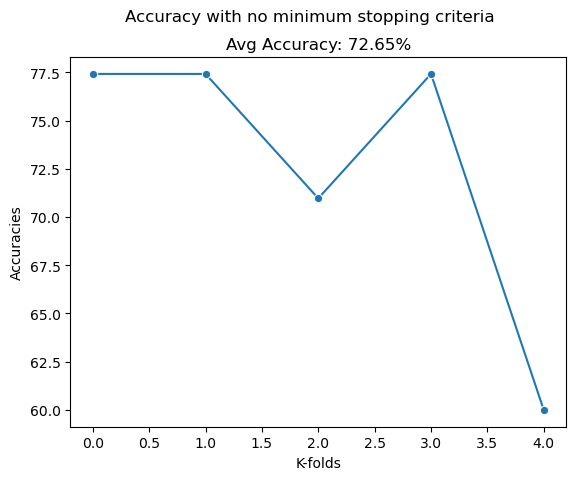

In [18]:
model = DecisionTreeClassifier(max_depth=float('inf'), min_samples_split=2, min_samples_leaf=1, features=None, mode='entropy')
data = cross_validation(X, Y, model, k=5)
avg_accuracy = round(np.mean(data['accuracies']), 2)
plt.suptitle('Accuracy with no minimum stopping criteria')
plt.title(f'Avg Accuracy: {avg_accuracy}%')
sns.lineplot(data['accuracies'], marker='o')
plt.xlabel('K-folds')
plt.ylabel('Accuracies')
plt.show()

nodes of the minimum limitations

In [19]:
leaf_info = model.get_all_leaf_info()

for leaf_id, distribution in leaf_info.items():
    print(f"Leaf Node ID: {leaf_id}, Class Distribution: {distribution}")

Leaf Node ID: 7, Class Distribution: {5.0: 1.0}
Leaf Node ID: 143, Class Distribution: {2.0: 1.0}
Leaf Node ID: 289, Class Distribution: {4.0: 1.0}
Leaf Node ID: 290, Class Distribution: {2.0: 1.0}
Leaf Node ID: 72, Class Distribution: {1.0: 1.0}
Leaf Node ID: 295, Class Distribution: {2.0: 1.0}
Leaf Node ID: 296, Class Distribution: {4.0: 1.0}
Leaf Node ID: 148, Class Distribution: {2.0: 1.0}
Leaf Node ID: 599, Class Distribution: {4.0: 1.0}
Leaf Node ID: 600, Class Distribution: {2.0: 1.0}
Leaf Node ID: 300, Class Distribution: {4.0: 1.0}
Leaf Node ID: 150, Class Distribution: {2.0: 1.0}
Leaf Node ID: 37, Class Distribution: {1.0: 1.0}
Leaf Node ID: 311, Class Distribution: {6.0: 1.0}
Leaf Node ID: 312, Class Distribution: {4.0: 1.0}
Leaf Node ID: 156, Class Distribution: {6.0: 1.0}
Leaf Node ID: 78, Class Distribution: {2.0: 1.0}
Leaf Node ID: 9, Class Distribution: {3.0: 1.0}
Leaf Node ID: 21, Class Distribution: {2.0: 1.0}
Leaf Node ID: 22, Class Distribution: {3.0: 1.0}
Leaf Node

### `Scenario 2`: Best Combinition of Parameters (Pre-Pruning)

In [20]:
from itertools import product

max_depths = [5, 12, 25]
min_samples_splits = [4, 10]
min_samples_leafs = [1, 2]
features = [None, [4, 5]]
modes = ['entropy', 'gini']

param_combinitions = list(product(max_depths, min_samples_splits, min_samples_leafs, features, modes))
print(f'Total combinitions: {len(param_combinitions)}')

Total combinitions: 48


In [21]:
accuracies = []
for param in param_combinitions:
    max_depth = param[0]
    min_samples_split = param[1]
    min_samples_leaf = param[2]
    feature = param[3]
    mode = param[4]
    
    model = DecisionTreeClassifier(max_depth, min_samples_split, min_samples_leaf, feature, mode)
    data = cross_validation(X, Y, model, k=5)
    avg_accuracy = round(np.mean(data['accuracies']), 2)
    accuracies.append(avg_accuracy)
    
plt.suptitle('Accuracy with Combos')
sns.lineplot(accuracies, marker='o')
plt.xlabel('Combo')
plt.ylabel('Accuracies')
plt.show()

KeyboardInterrupt: 

In [ ]:
indices = np.argsort(accuracies)[::-1]
top_5 = np.array(accuracies)[indices[:5]]
least_5 = np.array(accuracies)[indices[-5:]]
print(f'Accuracies top 5: {top_5}')
print(f'Combinition')
print([param_combinitions[i] for i in indices[:5]])
print()
print(f'Accuracies least 5: {least_5}')
print(f'Combinition')
print([param_combinitions[i] for i in indices[-5:]])

Accuracies top 5: [80.59 80.44 80.37 79.87 79.45]
Combinition
[(12, 4, 2, None, 'entropy'), (12, 4, 1, None, 'gini'), (5, 10, 1, None, 'entropy'), (25, 4, 2, None, 'gini'), (5, 10, 1, None, 'gini')]

Accuracies least 5: [58.89 58.38 58.3  57.81 56.66]
Combinition
[(25, 4, 2, [4, 5], 'entropy'), (5, 4, 2, [4, 5], 'gini'), (12, 10, 1, [4, 5], 'gini'), (5, 4, 1, [4, 5], 'gini'), (25, 10, 2, [4, 5], 'entropy')]


In [ ]:
leaf_info = model.get_all_leaf_info()

for leaf_id, distribution in leaf_info.items():
    print(f"Leaf Node ID: {leaf_id}, Class Distribution: {distribution}")

Leaf Node ID: 3, Class Distribution: {5.0: 1.0}
Leaf Node ID: 319, Class Distribution: {5.0: 0.5, 2.0: 0.5}
Leaf Node ID: 641, Class Distribution: {2.0: 0.5, 4.0: 0.5}
Leaf Node ID: 642, Class Distribution: {2.0: 0.88, 4.0: 0.12}
Leaf Node ID: 160, Class Distribution: {4.0: 1.0}
Leaf Node ID: 161, Class Distribution: {2.0: 1.0}
Leaf Node ID: 162, Class Distribution: {4.0: 0.5, 2.0: 0.5}
Leaf Node ID: 40, Class Distribution: {1.0: 0.1, 4.0: 0.6, 2.0: 0.3}
Leaf Node ID: 20, Class Distribution: {1.0: 0.83, 4.0: 0.17}
Leaf Node ID: 87, Class Distribution: {3.0: 0.8, 2.0: 0.2}
Leaf Node ID: 355, Class Distribution: {4.0: 0.11, 2.0: 0.78, 3.0: 0.11}
Leaf Node ID: 356, Class Distribution: {6.0: 0.6, 4.0: 0.2, 1.0: 0.2}
Leaf Node ID: 178, Class Distribution: {3.0: 0.67, 2.0: 0.33}
Leaf Node ID: 44, Class Distribution: {0.0: 1.0}
Leaf Node ID: 45, Class Distribution: {6.0: 0.17, 3.0: 0.33, 2.0: 0.5}
Leaf Node ID: 93, Class Distribution: {6.0: 0.5, 2.0: 0.5}
Leaf Node ID: 94, Class Distribution:

- max depth, min samples, leaf, and modes don't seem to effect
- but, the mode has a little tendency, entropy is better 
- model performs better when the features are not limited 

### `Scenario 3`: Cost Complexity VS Reduced Error (Post-Pruning) 

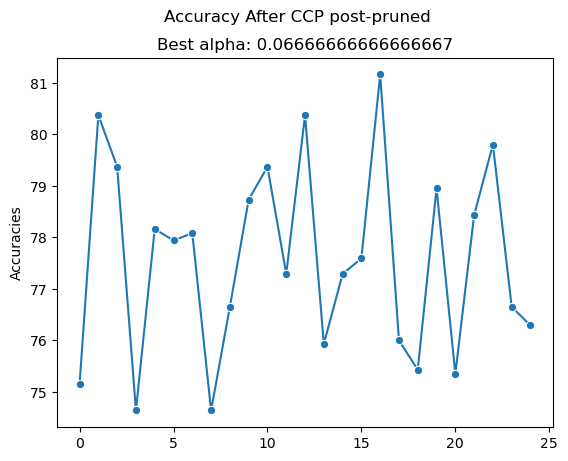

In [ ]:
model = DecisionTreeClassifier(max_depth=15, min_samples_split=2, min_samples_leaf=1, features=None, mode='entropy')
alphas = np.linspace(0, 0.1, 25)
accuracies = []
for alpha in alphas:
    data = cross_validation(X, Y, model, k=5, pruning='ccp', alpha=alpha)
    avg_accuracy = round(np.mean(data['accuracies']), 2)
    accuracies.append(avg_accuracy)
best_alpha_index = np.argsort(accuracies)[::-1][0]
best_alpha = alphas[best_alpha_index]
plt.suptitle('Accuracy After CCP post-pruned')
plt.title(f'Best alpha: {best_alpha}')
sns.lineplot(accuracies, marker='o')
plt.ylabel('Accuracies')
plt.show()

In [ ]:
data = cross_validation(X, Y, model, k=5, pruning='ccp', alpha=best_alpha)
avg_accuracy = round(np.mean(data['accuracies']), 2)
print(f'Best alpha {best_alpha} accuracy: {avg_accuracy}%')

Best alpha 0.06666666666666667 accuracy: 80.24%


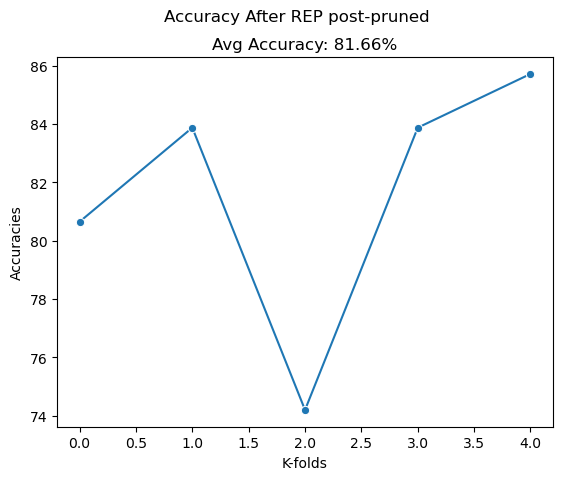

In [ ]:
model = DecisionTreeClassifier(max_depth=15, min_samples_split=2, min_samples_leaf=1, features=None, mode='entropy')
data = cross_validation(X, Y, model, k=5, pruning='rep')
avg_accuracy = round(np.mean(data['accuracies']), 2)
plt.suptitle('Accuracy After REP post-pruned')
plt.title(f'Avg Accuracy: {avg_accuracy}%')
sns.lineplot(data['accuracies'], marker='o')
plt.xlabel('K-folds')
plt.ylabel('Accuracies')
plt.show()

nodes after REP

In [ ]:
leaf_info = model.get_all_leaf_info()

for leaf_id, distribution in leaf_info.items():
    print(f"Leaf Node ID: {leaf_id}, Class Distribution: {distribution}")

Leaf Node ID: 63, Class Distribution: {1.0: 0.67, 4.0: 0.33}
Leaf Node ID: 259, Class Distribution: {2.0: 1.0}
Leaf Node ID: 521, Class Distribution: {4.0: 1.0}
Leaf Node ID: 522, Class Distribution: {4.0: 0.5, 2.0: 0.5}
Leaf Node ID: 130, Class Distribution: {2.0: 1.0}
Leaf Node ID: 32, Class Distribution: {4.0: 0.44, 6.0: 0.44, 2.0: 0.11}
Leaf Node ID: 16, Class Distribution: {1.0: 1.0}
Leaf Node ID: 8, Class Distribution: {2.0: 0.93, 4.0: 0.07}
Leaf Node ID: 19, Class Distribution: {5.0: 1.0}
Leaf Node ID: 20, Class Distribution: {2.0: 0.25, 4.0: 0.75}
Leaf Node ID: 10, Class Distribution: {3.0: 1.0}
Leaf Node ID: 11, Class Distribution: {6.0: 0.5, 0.0: 0.5}
Leaf Node ID: 12, Class Distribution: {0.0: 1.0}
Leaf Node ID: 6, Class Distribution: {2.0: 1.0}


the rep performs better in accuracy, the most optimal is tree after post pruned with REP method

### `Evaluation`: Confusion Matrix 

In [ ]:
test_indices = data['test']
train_indices = data['train']
y_pred_test = [int(x) for x in model.predict(df.iloc[test_indices, :-1].values)]
y_pred_train = [int(x) for x in model.predict(df.iloc[train_indices, :-1].values)]

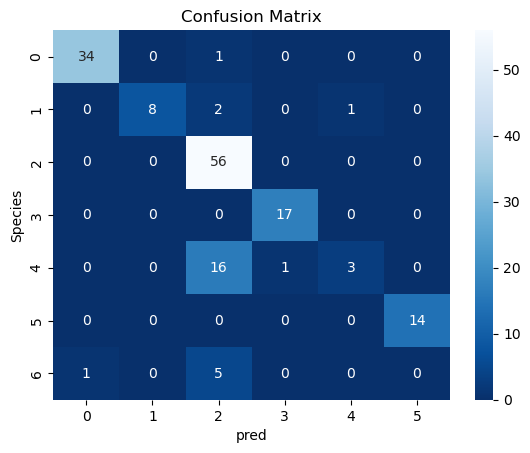

Species
2    56
0    35
4    20
3    17
5    14
1    11
6     6
Name: count, dtype: int64

pred
2    80
0    35
3    18
5    14
1     8
4     4
Name: count, dtype: int64

In [ ]:
df['pred'] = 0
df.loc[test_indices, 'pred'] = y_pred_test
df.loc[train_indices, 'pred'] = y_pred_train
crosstab_confusion_matrix = pd.crosstab(df['Species'], df['pred'])
plt.title('Confusion Matrix')
sns.heatmap(crosstab_confusion_matrix, annot=True, cmap='Blues_r')
plt.show()
display(df['Species'].value_counts())
display(df['pred'].value_counts())

In [ ]:
import numpy as np
import pandas as pd

def classification_report(y_true, y_pred):
    classes = np.unique(y_true)  # Get unique class labels
    report_data = []

    # Compute accuracy
    accuracy = np.sum(y_true == y_pred) / len(y_true)

    for cls in classes:
        # True Positives (TP): Correctly predicted as class cls
        TP = np.sum((y_pred == cls) & (y_true == cls))

        # False Positives (FP): Incorrectly predicted as class cls
        FP = np.sum((y_pred == cls) & (y_true != cls))

        # False Negatives (FN): Incorrectly predicted as another class
        FN = np.sum((y_pred != cls) & (y_true == cls))

        # precision: ratio of rightly predicted among the right class (ex: 72% real, 18% predicted as not but actually real)
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
        # recall: ratio of the real among predicted (ex: 80% real, 20% predicted as real but not)
        recall = TP / (TP + FN) if (TP + FP) > 0 else 0.0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

        report_data.append([cls, precision, recall, f1_score])

    # Create a pandas DataFrame
    report_df = pd.DataFrame(report_data, columns=["Class", "Precision", "Recall", "F1 Score"])
    
    # Append overall accuracy
    report_df.loc["Accuracy"] = ["-", "-", "-", accuracy]

    return report_df

report = classification_report(df['Species'].values, df['pred'].values)
display(report)


,Class,Precision,Recall,F1 Score
0,0,0.971429,0.971429,0.971429
1,1,1.0,0.727273,0.842105
2,2,0.7,1.0,0.823529
3,3,0.944444,1.0,0.971429
4,4,0.75,0.15,0.250000
5,5,1.0,1.0,1.000000
6,6,0.0,0.0,0.000000
Accuracy,-,-,-,0.830189


### `Evaluation`: AOC and ROC plot

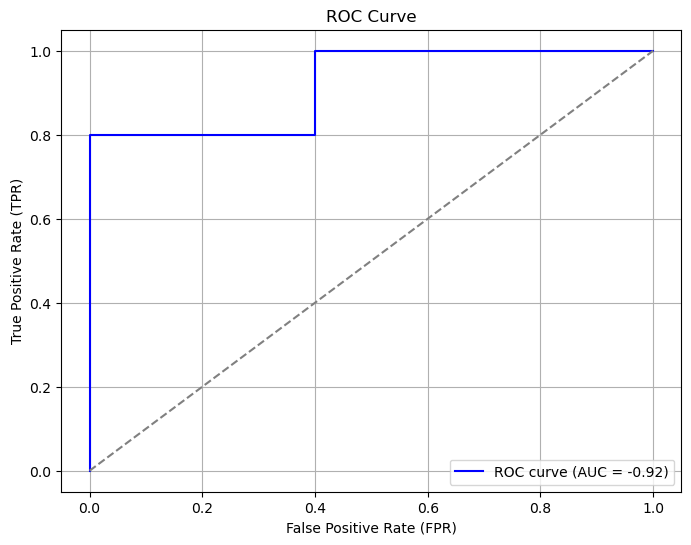

AUC Score: -0.92


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Helper functions to calculate TPR, FPR
def compute_metrics(y_true, y_pred, threshold):
    """
    Compute confusion matrix elements and TPR, FPR for a given threshold.
    """
    y_pred_bin = (y_pred >= threshold).astype(int)
    
    TP = np.sum((y_true == 1) & (y_pred_bin == 1))
    TN = np.sum((y_true == 0) & (y_pred_bin == 0))
    FP = np.sum((y_true == 0) & (y_pred_bin == 1))
    FN = np.sum((y_true == 1) & (y_pred_bin == 0))
    
    TPR = TP / (TP + FN)  # Recall or Sensitivity
    FPR = FP / (FP + TN)  # Fall-out
    
    return TPR, FPR

# Function to plot ROC curve and calculate AUC from scratch
def plot_roc_auc(y_true, y_pred_scores):
    thresholds = np.linspace(0, 1, 100)  # Vary the threshold from 0 to 1
    TPRs = []
    FPRs = []
    
    # Loop through all thresholds to compute TPR and FPR
    for threshold in thresholds:
        TPR, FPR = compute_metrics(y_true, y_pred_scores, threshold)
        TPRs.append(TPR)
        FPRs.append(FPR)
    
    # Convert lists to numpy arrays for easier manipulation
    TPRs = np.array(TPRs)
    FPRs = np.array(FPRs)
    
    # Calculate AUC using the trapezoidal rule
    auc = np.trapz(TPRs, FPRs)
    
    # Plot the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(FPRs, TPRs, color='blue', label=f'ROC curve (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier line
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()
    
    return auc

# Example usage:
# Assuming y_true is your true labels and y_pred_scores is the predicted probabilities
y_true = np.array([0, 0, 1, 1, 0, 1, 1, 0, 1, 0])  # Example true labels
y_pred_scores = np.array([0.1, 0.4, 0.35, 0.8, 0.2, 0.9, 0.95, 0.3, 0.85, 0.6])  # Example predicted scores

# Plot ROC curve and calculate AUC
auc_score = plot_roc_auc(y_true, y_pred_scores)
print(f'AUC Score: {auc_score:.2f}')


### New Instance

In [ ]:
new_instance = df.iloc[90].values  # Example instance
leaf_id, confidence_scores = model.get_leaf_info(new_instance)

print(f"Leaf Node ID: {leaf_id}")
print(f"Confidence Scores: {confidence_scores}")


Leaf Node ID: 8
Confidence Scores: {2.0: 0.93, 4.0: 0.07}


In [ ]:
df.iloc[90]

Weight     110.0000
Length1     20.0000
Length2     22.0000
Length3     23.5000
Height       5.5225
Width        3.9950
pred         2.0000
Species      2.0000
Name: 90, dtype: float64